## Previsão de Séries Temporais do Custeio Administrativo do Governo Federal utilizando Sarima

As séries temporais são conjuntos de dados organizados em ordem cronológica, onde cada observação está associada a um momento específico no tempo. Essa estrutura de dados é amplamente utilizada em diferentes áreas, como economia, finanças, meteorologia e muitas outras, devido à sua natureza sequencial e à capacidade de capturar padrões e tendências ao longo do tempo.

Gostaria de ter utilizado outros dados que são mais próximos do cotidiano, no entanto, muitos não posso divulgar por questões legais, então me baseei neste que está na base de dados abertos.

É importante salientar que há diversos outros fatores (econômicos, políticos, geopolíticos) que influenciam na previsão dessa despesa. Para mais detalhes sobre o Custeio Administrativo, é possível encontrar na Lei nº 4.320/1964, art. 12, § 1º, "Gastos com manutenção de serviços anteriormente criados, inclusive os destinados a atender a obras de conservação e adaptação de bens imóveis."
Basicamente são despesas públicas encontradas no rol de Despesas Correntes e não geram aumento de patrimônio para o Estado, apenas manutenção dos serviços já existentes.

Link dos dados: https://www.tesourotransparente.gov.br/visualizacao/series-temporais-do-tesouro-nacional

### 1) EDA (Exploratory Data Analysis) e ETL (Extract, Transform e Load)

### 1.1) Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import r2_score
from sklearn.ensemble import IsolationForest
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1.2) Carregamento do arquivo e Limpeza

In [2]:
df = pd.read_csv('./dados/Custeio_Administrativo.csv',sep=';')

In [3]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

In [4]:
df = df.sort_values(by='Data', ascending=True)

In [5]:
df.set_index('Data', inplace=True)

In [6]:
df['Valor'] = df['Valor'].str.replace('.', '').str.replace(',', '.')
df['Valor'] = df['Valor'].astype(float)

In [7]:
# Separação dos arquivos para poder comparar a previsão com os dados reais mais para frente
# Os dados de treino serão o df e a previsão será comparada com df_2022
df_2022 = df.loc[df.index >= '2022-06-01']
df = df.loc[df.index < '2022-06-01']

In [8]:
df_2022.head()

,Valor
Data,
2022-06-01,4141.02
2022-07-01,4295.70
2022-08-01,4329.34
2022-09-01,4915.18
2022-10-01,3922.65


In [9]:
df.tail()

,Valor
Data,
2022-01-01,2024.88
2022-02-01,3033.48
2022-03-01,4195.21
2022-04-01,4068.50
2022-05-01,4768.20


### 1.3) Função de uma das métricas que usarei para avaliar o modelo

O Erro Médio Absoluto em Percentual (MAPE):

$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{Atual - Previsto}{Atual}\right| \times 100$


In [10]:
def mape(atual, pred):
    mask = atual != 0
    atual_nonzero = atual[mask]
    pred_nonzero = pred[mask]
    return np.abs((atual_nonzero - pred_nonzero) / atual_nonzero).sum() / len(atual_nonzero) * 100

### 1.4) Observação dos dados para fazer a modelagem estatística
Claramente há picos de sazonalidade, mas é preciso avaliar outras métricas

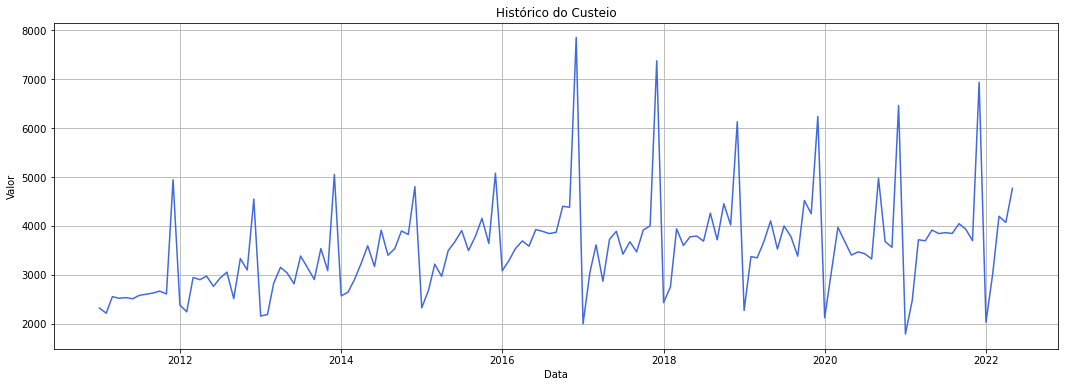

In [11]:
y = df['Valor']

fig, ax = plt.subplots(figsize=(18,6))
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Histórico do Custeio')
plt.grid()
ax.plot(y, color='#4169E1')
plt.show()

In [12]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Esta série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Esta série provavelmente é estacionária.')        

<p>A ideia são os valores críticos ficarem o mais próximo possível do teste estatístico, de qualquer forma, esses valores sendo inferiores significa que não é estacionária.</p>
<p>O resultado mostrou que a série não é estacionária, então não tem média que se repete de tempos em tempos (não necessariamente implica em sazonalidade, esta foi identificada por causa dos ciclos periódicos).</p>

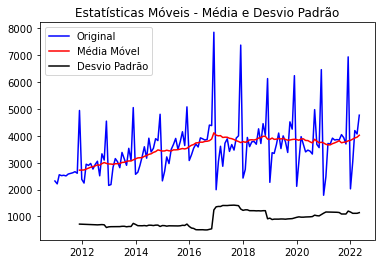


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.986070
Valor-p                           0.292714
Número de Lags Consideradas      11.000000
Número de Observações Usadas    125.000000
Valor Crítico (1%)               -3.483779
Valor Crítico (5%)               -2.884954
Valor Crítico (10%)              -2.579257
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Esta série provavelmente não é estacionária.


In [13]:
testa_estacionaridade(df)

### 1.5) Análise de Sazonalidade (SAC) para identificar o Lag
Foi identificado uma correlação significativa das observações passadas com as atuais para ajustar melhor a previsão com lag de 30. Testei também com 24 para poder calcular a diferenciação, mas o resultado não foi muito diferente mesmo estando fora do intervalo de confiança.

<ul>
    <li>ts: transformação em série</li>
    <li>nlags: quantidade de lags que usei para teste</li>
<li>qstat: avalia se o lag é significativo (se for menor que o nível de significância é significativo)</li>
<li>fft: transformada de Fourier para acelerar o cálculo SAC</li>
<li>alpha: nível de significância</li>
</ul>

In [14]:
ts = df['Valor']
sac, confint, qstat, pvalues = sm.tsa.acf(ts, nlags=30, qstat=True, fft=True, alpha=0.05)

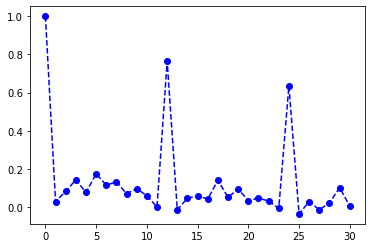

In [15]:
plt.plot(range(len(sac)), sac, marker='o', linestyle='--', color='b')

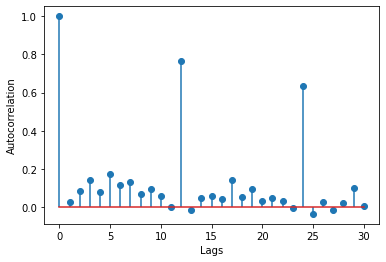

In [16]:
plt.stem(sac, use_line_collection=True)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [17]:
# com lag abaixo não estava
lim_inf = confint[30,0]
lim_sup = confint[30,1]

if lim_inf <= 0 <= lim_sup:
    print('O número 0 está contindo no intervalo de confiança para esse lag.')
else:
    print('Não está')

O número 0 está contindo no intervalo de confiança para esse lag.


### 1.6) Cálculo da diferenciação
Pelo teste, uma diff foi suficiente para estabilizar a variância e tornar a série estacionária para realizar previsões.

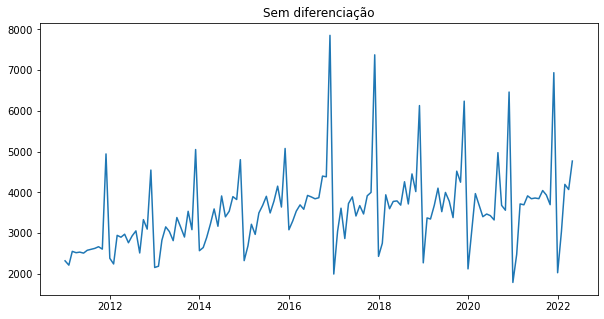

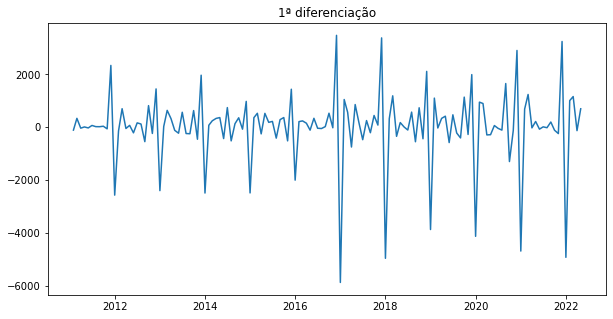

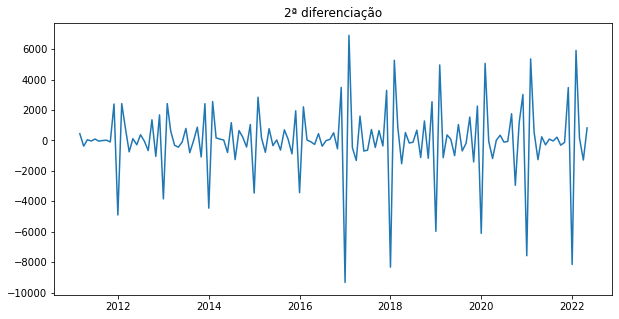

In [18]:
plt.figure(figsize=(10,5))
plt.title('Sem diferenciação')
plt.plot(df)
plt.show()

plt.figure(figsize=(10,5))
plt.title('1ª diferenciação')
plt.plot(df.diff())
plt.show()

plt.figure(figsize=(10,5))
plt.title('2ª diferenciação')
plt.plot(df.diff().diff())
plt.show()

In [19]:
diff1 = df.diff().dropna()
diff2 = df.diff().diff().dropna()

### 1.7) Correlograma lollipop
Busquei identificar os parâmetros p,d,q,P,D,Q para utilizá-los no Auto Arima

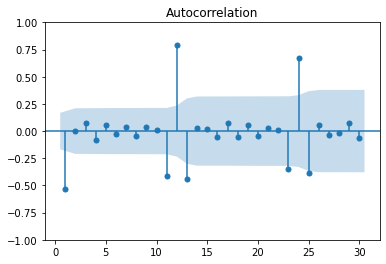

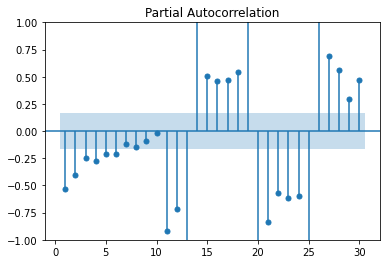

In [20]:
plot_acf(diff1, lags = 30, zero=False);
plot_pacf(diff1, lags = 30, zero=False);

Sazonalidade bem marcante a cada 6 e 12 meses

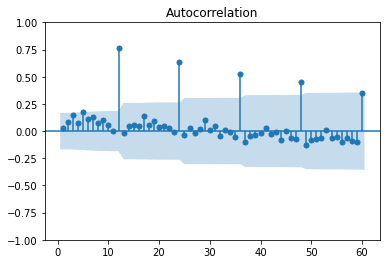

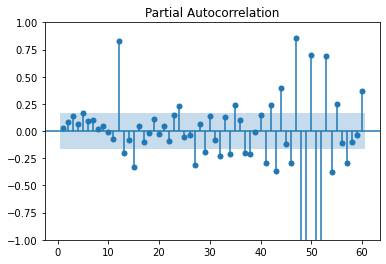

In [21]:
plot_acf(df, lags = 60, zero=False);
plot_pacf(df, lags = 60, zero=False);

## 2) Construção do Modelo para Previsão

### 2.1) Utilização dos parâmetros definidos anteriormente

In [22]:
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=2, max_q=7, seazonal=True,
                      m=30,
                      D=1,
                      start_P=1,
                      start_Q=1,
                      max_P=2,
                      max_Q=2,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[30]             : AIC=1710.397, Time=4.58 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=1915.728, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=2.08 sec
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=4.67 sec
 ARIMA(1,1,1)(1,1,0)[30]             : AIC=1708.439, Time=2.40 sec
 ARIMA(1,1,1)(0,1,0)[30]             : AIC=1835.128, Time=0.47 sec
 ARIMA(1,1,1)(2,1,0)[30]             : AIC=1710.396, Time=11.02 sec
 ARIMA(1,1,1)(2,1,1)[30]             : AIC=inf, Time=17.99 sec
 ARIMA(0,1,1)(1,1,0)[30]             : AIC=1706.743, Time=1.54 sec
 ARIMA(0,1,1)(0,1,0)[30]             : AIC=1835.697, Time=0.31 sec
 ARIMA(0,1,1)(2,1,0)[30]             : AIC=1708.642, Time=8.11 sec
 ARIMA(0,1,1)(1,1,1)[30]             : AIC=1708.647, Time=2.38 sec
 ARIMA(0,1,1)(2,1,1)[30]             : AIC=inf, Time=17.51 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AI

In [23]:
# O Best Model não estava ruim, mas modifiquei um pouco e encontrei um resultado melhor
order = (2, 1, 1)
seasonal_order = (1, 1, 2, 30)

### 2.2) Criação do Modelo

<p>Forcei a quantidade de iterações e diminui os valores de ftol e xtol para fazer rodar mais vezes, mesmo assim não houve necessidade de usar muito poder computacional com method lbfgs (default).</p> <p>Fiz outros testes também com powell (otimização que não requer cálculo de derivadas), bfgs (otimização sem restrições que utiliza aproximações da matriz Hessiana), newton (otimização baseado no método de Newton-Raphson, que requer a especificação da matriz Hessiana)</p>
<p>Mantive o padrão porque o resultado não melhorou<p>

In [24]:
model = sm.tsa.statespace.SARIMAX(df, order=order,seasonal_order=seasonal_order).fit(max_iter = 50, method = 'lbfgs', ftol=1e-8, xtol=1e-8)
forecast = model.get_forecast(steps = 12)

In [25]:
predicted_values = forecast.predicted_mean
index = pd.date_range(start=df.index[-1], periods=len(predicted_values), freq='M')

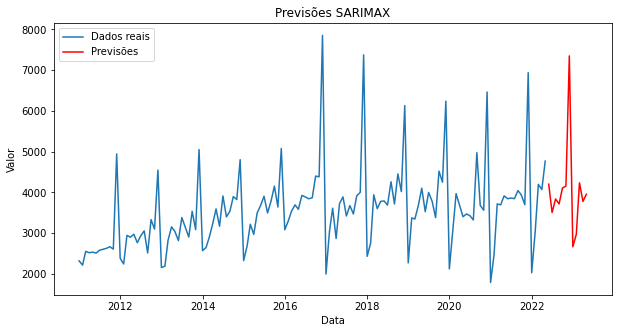

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(df, label='Dados reais')
plt.plot(predicted_values, color='r', label='Previsões')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsões SARIMAX')
plt.legend()
fig = plt.gcf()
plt.show()
fig.savefig('./graficos/Sarima.png', format='png')

### 2.3) Comparação do que foi previsto com o que de fato aconteceu

In [27]:
comparacao = pd.merge(df_2022, predicted_values, left_index=True, right_index=True)

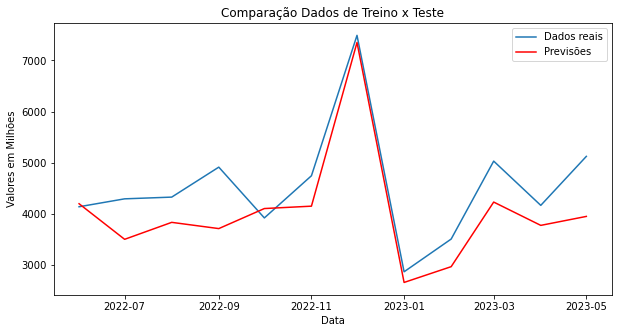

In [28]:
# comparacao.plot()

plt.figure(figsize=(10, 5))
plt.plot(comparacao['Valor'], label='Dados reais')
plt.plot(comparacao['predicted_mean'], color='r', label='Previsões')
plt.xlabel('Data')
plt.ylabel('Valores em Milhões')
plt.title('Comparação Dados de Treino x Teste')
plt.legend()
fig = plt.gcf()
plt.show()
fig.savefig('./graficos/TreinoxTeste.png', format='png')

### 3) Avaliação da Previsão
<p>Mape: quanto mais baixo melhor</p>
<p>R²: quanto mais próximo de 1 (100%) melhor</p>

In [29]:
mape_sarima = mape(comparacao.iloc[-12:, 0], comparacao.iloc[-12:, 1])
print(f'MAPE: {mape_sarima:.2f} %')

MAPE: 12.13 %


In [30]:
r2 = r2_score(comparacao.iloc[-12:, 0], comparacao.iloc[-12:, 1])
print(f'R²: {r2:.2f}')

R²: 0.63


### 4) Considerações Finais:

Após a implementação do modelo de previsão e a realização de avaliações cuidadosas, foram obtidos resultados promissores na capacidade de prever a série temporal com base nos dados coletados. A qualidade do modelo foi avaliada por meio de análises quantitativas e, quando relevante, também foram considerados aspectos qualitativos para garantir a relevância e a utilidade das previsões geradas.

Os resultados obtidos fornecem uma base sólida para a aplicação prática das previsões em cenários reais, auxiliando a tomada de decisões informadas e estratégicas em relação aos dados temporais analisados. No entanto, é importante ressaltar que a precisão do modelo pode ser afetada por mudanças nas tendências e comportamentos futuros, portanto, o monitoramento contínuo e a atualização do modelo com novos dados são aspectos relevantes para sua aplicação a longo prazo.